In [1]:
import pandas as pd
import os 
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import fisher_exact
import gseapy as gp


In [2]:
cols_to_read = ["gene_name", "upregulated", "downregulated"]
real = pd.read_csv("560_real.csv", usecols=cols_to_read)
synth = pd.read_csv("560_synth.csv", usecols=cols_to_read)

# sourcery skip: avoid-builtin-shadow
real_genes = set(real.gene_name)    
synth_genes = set(synth.gene_name)

# details
print(f"Real genes: {len(real_genes)}")
print(f"All genes: {len(synth_genes)}")
print(f"Real genes not in synth: {len(real_genes - synth_genes)}")
print(f"Crossection: {len(real_genes & synth_genes)}")

# taking crossection
common_genes = list(set(real.gene_name)  & set(synth.gene_name))
real = real[real.gene_name.isin(common_genes)]
synth = synth[synth.gene_name.isin(common_genes)]

# dropping not_found gene ids
real = real[real.gene_name != "not_found"]
synth = synth[synth.gene_name != "not_found"]


Real genes: 30672
All genes: 30862
Real genes not in synth: 3263
Crossection: 27409


In [3]:
values = pd.merge(real, synth, on="gene_name", suffixes=["_real", "_synth"])
values.head()

,downregulated_real,upregulated_real,gene_name,downregulated_synth,upregulated_synth
0,78.0,153.0,TSPAN6,181.0,445.0
1,43.0,211.0,TNMD,62.0,236.0
2,75.0,388.0,DPM1,237.0,398.0
3,381.0,628.0,SCYL3,277.0,490.0
4,1112.0,4073.0,C1orf112,1654.0,2608.0


In [4]:
def calculate_log2_odds_ratio(a, b, c, d, k=0.5):
    # a, b, c, d are the four cells of the 2x2 contingency table
    # k is the smoothing constant
    #
    odds_ratio = ((a + k) * (d + k)) / ((b + k) * (c + k))
    return np.log2(odds_ratio)

# laplace smoothing with k=0.5 (s prior)
values['log2_odds_ratio'] = values.apply(lambda row: calculate_log2_odds_ratio(
    row['upregulated_real'], 
    row['downregulated_real'], 
    row['upregulated_synth'], 
    row['downregulated_synth']
), axis=1)

values.head()

,downregulated_real,upregulated_real,gene_name,downregulated_synth,upregulated_synth,log2_odds_ratio
0,78.0,153.0,TSPAN6,181.0,445.0,-0.327982
1,43.0,211.0,TNMD,62.0,236.0,0.361658
2,75.0,388.0,DPM1,237.0,398.0,1.616714
3,381.0,628.0,SCYL3,277.0,490.0,-0.101536
4,1112.0,4073.0,C1orf112,1654.0,2608.0,1.215638


In [5]:
def calculate_pseudocount(df):
    total_counts = df[['upregulated_real', 'downregulated_real', 'upregulated_synth', 'downregulated_synth']].sum().sum()
    return 1 / total_counts

pseudocount = calculate_pseudocount(values)


In [6]:
def perform_fisher_test_vectorized(df, pseudocount=0.5):
    # Add pseudocount to the table
    table = np.array([
        [df['upregulated_real'] + pseudocount, df['downregulated_real'] + pseudocount],
        [df['upregulated_synth'] + pseudocount, df['downregulated_synth'] + pseudocount]
    ]).transpose((2, 0, 1))  # reshape for 2x2 tables

    p_values = np.zeros(len(df))

    for i in range(len(df)):
        _, p_values[i] = fisher_exact(table[i])

    df['p_value'] = p_values
    df['p_adj'] = multipletests(p_values, method='fdr_bh')[1]
    
    return df
def add_z_score(df):
    # Calculate mean and standard deviation of log2 odds ratios
    mean_log2or = df['log2_odds_ratio'].mean()
    std_log2or = df['log2_odds_ratio'].std()
    
    # Calculate Z-score
    df['z_score'] = (df['log2_odds_ratio'] - mean_log2or) / std_log2or
    
    return df


df = perform_fisher_test_vectorized(values, pseudocount=pseudocount)
df = add_z_score(df)

df.head()

,downregulated_real,upregulated_real,gene_name,downregulated_synth,upregulated_synth,log2_odds_ratio,p_value,p_adj,z_score
0,78.0,153.0,TSPAN6,181.0,445.0,-0.327982,1.802069e-01,2.344898e-01,-0.154673
1,43.0,211.0,TNMD,62.0,236.0,0.361658,2.770271e-01,3.433925e-01,0.128735
2,75.0,388.0,DPM1,237.0,398.0,1.616714,6.575761e-15,4.412109e-14,0.644500
3,381.0,628.0,SCYL3,277.0,490.0,-0.101536,4.877243e-01,5.625146e-01,-0.061615
4,1112.0,4073.0,C1orf112,1654.0,2608.0,1.215638,6.528587e-76,3.191691e-73,0.479678


In [7]:
df.loc[:, 'rank'] = df["log2_odds_ratio"] * (-np.log10(df["p_adj"]))
df_sorted = df.sort_values('rank')


# Create a Series with gene names as index and ranks as values
ranked_genes = df_sorted.set_index('gene_name')['rank']


In [8]:
ranked_genes

gene_name
snoU13          -1023.153096
snoU13           -818.281431
NCF1B            -815.780773
snoU13           -701.939111
Y_RNA            -619.059569
                    ...     
RNU6-662P         642.727766
TRGC2             691.327757
RP11-79H23.3      696.194684
RP11-361F15.2     745.701536
RP11-421L10.1     802.256143
Name: rank, Length: 28355, dtype: float64

In [11]:
df[df.gene_name == "TRGC2"]

,downregulated_real,upregulated_real,gene_name,downregulated_synth,upregulated_synth,log2_odds_ratio,p_value,p_adj,z_score,rank
19628,11.0,345.0,TRGC2,176.0,31.0,7.395224,1.855628e-97,3.288521e-94,3.019182,691.327757


In [12]:
df = pd.read_csv('/Volumes/TYPE C/inbox/result_real.csv')


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/TYPE C/inbox/result_real.csv'

In [7]:
df.loc[:, 'rank'] = df["log2_odds_ratio"] * (-np.log10(df["p_adj"]))
df_sorted = df.sort_values('rank')


# Create a Series with gene names as index and ranks as values
ranked_genes = df_sorted.set_index('gene_name')['rank']

# Run preranked GSEA
pre_res = gp.prerank(rnk=ranked_genes, 
                     gene_sets='KEGG_2021_Human',
                     threads=4,
                     permutation_num=1000,
                     min_size=5,
                     max_size=5000,
                     outdir='gsea_results/prerank_result',
                     format='png')


results = pre_res.res2d


sorted_results = results.sort_values('FDR q-val')

sorted_results

2024-10-11 01:17:22,781 [WARNING] Duplicated values found in preranked stats: 3.94% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
73,prerank,Neutrophil extracellular trap formation,-0.502947,-1.149982,0.183398,0.820386,1.0,18/103,14.64%,TLR2;NFKB1;NCF1;MAPK1;PADI4;FCGR3A;TLR7;HDAC2;...
77,prerank,Amphetamine addiction,-0.532395,-1.140398,0.241379,0.824654,1.0,8/64,7.19%,CREB3;MAOA;PPP1CC;FOS;PPP3CA;PPP3R2;GNAS;HDAC2
76,prerank,Huntington disease,-0.45114,-1.142884,0.140594,0.825757,1.0,33/258,11.29%,CREB3;TUBA1B;REST;SDHA;TUBA4A;COX6A2;UCP1;SOD1...
72,prerank,MAPK signaling pathway,-0.451613,-1.15004,0.12753,0.833017,1.0,34/282,12.59%,CDC42;PLA2G4D;LAMTOR3;HSPA8;EGF;NFKB1;EREG;FOS...
75,prerank,Human T-cell leukemia virus 1 infection,-0.460293,-1.143672,0.149897,0.834768,1.0,38/207,15.06%,CREB3;CCNA2;NFKB1;HLA-G;NFKBIA;HLA-C;FOS;MAPK1...
...,...,...,...,...,...,...,...,...,...,...
225,prerank,Purine metabolism,0.368683,0.853715,0.794549,1.0,1.0,23/115,13.92%,NUDT9;ADPRM;DCK;PRPS1;GUCY1A2;IMPDH1;PAICS;NT5...
19,prerank,Toll-like receptor signaling pathway,-0.5916,-1.312216,0.070539,1.0,1.0,25/87,14.96%,TLR2;NFKB1;NFKBIA;SPP1;TICAM2;FOS;MAPK1;CD86;M...
18,prerank,Primary bile acid biosynthesis,0.777095,1.315656,0.133065,1.0,1.0,1/16,0.62%,CH25H
33,prerank,Olfactory transduction,0.520469,1.258471,0.075203,1.0,1.0,21/167,5.55%,OR4K13;OR8J3;OR6K2;OR4A16;OR5L1;OR6K3;OR3A1;OR...


In [8]:
df["rank"].describe()

count    28355.000000
mean        -0.021999
std         46.169363
min      -1023.153096
25%         -2.501990
50%          0.000000
75%          2.696049
max        802.256143
Name: rank, dtype: float64

In [9]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
df['rank_robust'] = scaler.fit_transform(df[['rank']])

from scipy import stats

def winsorize_and_normalize(x, limits=(0.05, 0.05)):
    x_winsorized = stats.mstats.winsorize(x, limits=limits)
    return stats.zscore(x_winsorized)

df['rank_winsor_z'] = winsorize_and_normalize(df['rank'])


def rank_based_inverse_normal(x):
    from scipy.stats import rankdata, norm
    ranked = rankdata(x)
    return norm.ppf((ranked - 0.5) / len(x))

df['rank_rint'] = rank_based_inverse_normal(df['rank'])


import numpy as np

def signed_log(x, pseudo_count=1):
    return np.sign(x) * np.log1p(np.abs(x) + pseudo_count)

df['rank_log'] = signed_log(df['rank'])





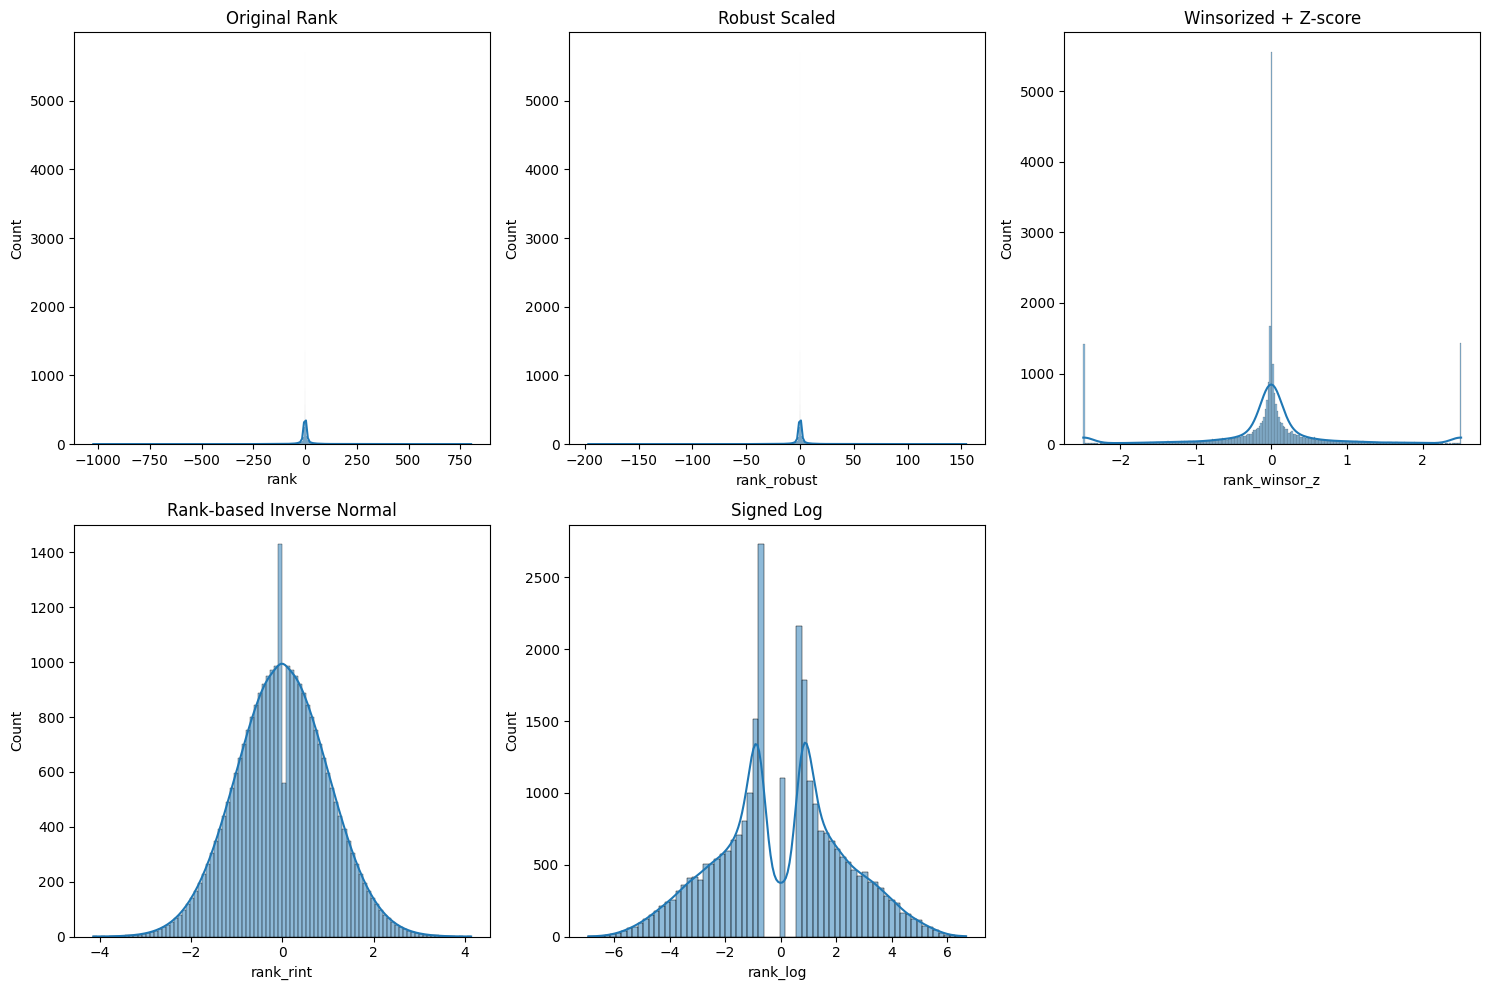

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))

plt.subplot(231)
sns.histplot(df['rank'], kde=True)
plt.title('Original Rank')

plt.subplot(232)
sns.histplot(df['rank_robust'], kde=True)
plt.title('Robust Scaled')

plt.subplot(233)
sns.histplot(df['rank_winsor_z'], kde=True)
plt.title('Winsorized + Z-score')

plt.subplot(234)
sns.histplot(df['rank_rint'], kde=True)
plt.title('Rank-based Inverse Normal')

plt.subplot(235)
sns.histplot(df['rank_log'], kde=True)
plt.title('Signed Log')

plt.tight_layout()
plt.show()


In [11]:
ranked_genes = df.set_index('gene_name')['rank_rint']  # replace with your chosen normalization

pre_res = gp.prerank(rnk=ranked_genes, 
                     gene_sets='KEGG_2021_Human',
                     threads=4,
                     permutation_num=1000,
                     min_size=5,
                     max_size=5000,
                     outdir='gsea_results/prerank_result_normalized',
                     format='png')


2024-10-11 01:18:28,923 [WARNING] Duplicated values found in preranked stats: 3.94% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [12]:
results = pre_res.res2d


sorted_results = results.sort_values('FDR q-val')

sorted_results

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
109,prerank,Graft-versus-host disease,-0.290376,-1.042339,0.379592,0.871897,1.0,10/33,16.43%,HLA-G;HLA-C;GZMB;CD86;FAS;HLA-DQA1;HLA-DRA;TNF...
106,prerank,Metabolism of xenobiotics by cytochrome P450,-0.253468,-1.045887,0.382166,0.875021,1.0,13/65,10.19%,UGT1A9;UGT2B17;ADH5;GSTA1;CYP2F1;GSTA2;UGT2B10...
105,prerank,Amyotrophic lateral sclerosis,-0.200629,-1.047991,0.312741,0.875752,1.0,91/314,25.80%,TUBA1B;SDHA;NUP37;HNRNPA3;TUBA4A;COX6A2;UBQLN1...
108,prerank,Alcoholism,-0.233371,-1.0435,0.347328,0.876329,1.0,39/97,32.03%,CREB3;GNG11;MAOA;PPP1CC;MAPK1;GNG5;SOS1;GNAS;H...
80,prerank,Arachidonic acid metabolism,-0.279104,-1.094971,0.291667,0.876613,1.0,11/54,12.65%,PLA2G4D;PLA2G2F;ALOX15;ALOX5;CYP2J2;PLA2G12B;C...
...,...,...,...,...,...,...,...,...,...,...
7,prerank,Chagas disease,-0.314951,-1.392277,0.033613,1.0,0.995,27/93,17.85%,TLR2;PPP2CA;NFKB1;NFKBIA;FOS;MAPK1;MAPK10;FAS;...
195,prerank,Calcium signaling pathway,0.175501,0.888119,0.802372,1.0,1.0,83/224,32.04%,ATP2B1;F2R;VDAC3;HTR5A;CALML3;ATP2B3;ITPKA;RET...
196,prerank,Staphylococcus aureus infection,0.206287,0.886362,0.696356,1.0,1.0,23/81,21.25%,HLA-DMA;DEFA5;DEFB1;KRT38;FPR1;KRT33A;HLA-DPA1...
13,prerank,Vitamin digestion and absorption,0.419295,1.329283,0.113281,1.0,1.0,7/22,21.05%,RBP2;AWAT2;PNLIP;BTD;SLC19A3;SLC19A2;ABCC1
